## Changing individual predictions

In this notebook, we show that Coar-Edit can change individual predictions of an ImageNet ResNet50 classifier without impacting its overall performance. This experiment reproduces our findings in Section 5.1 of our paper.

In [2]:
import os 
import sys 
sys.path.append('..')

import functools 
import torch
import torchvision
import numpy as np
import pandas as pd 
from torch import nn
import seaborn as sns
import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

from src.models import cifar_resnet
from src.utils import ndm_utils
from src.utils import data_utils
from src.utils import eval_utils
from src.utils import plot_utils
from src.data import ffcv_pipelines
import coar_edit

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download attributions

In [14]:
# note: ~20G
print ('Downloading dataloader (FFCV format)') 
!wget -nc 'https://www.dropbox.com/scl/fi/ovztah82lk6qav1bkhpn3/imagenet_val.beton?rlkey=eroq5kcusbwdfecxk0xscnu3n&dl=0' -O out/imagenet_val.beton

print ('Downloading attributions')
!wget 'https://www.dropbox.com/scl/fi/vd38pyjjyz1g7zu72r741/imagenet_resnet.pt?rlkey=45ideswhv9x3tyu7ctjcd84df&dl=0' -O out/imagenet_attb.pt

File ‘out/imagenet_val.beton’ already there; not retrieving.
--2024-02-14 15:38:14--  https://www.dropbox.com/scl/fi/vd38pyjjyz1g7zu72r741/imagenet_resnet.pt?rlkey=45ideswhv9x3tyu7ctjcd84df&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdbbe7c0329e385d57a26837175.dl.dropboxusercontent.com/cd/0/inline/CNT9bEzb7AfU5pq7M30q0OFyyRd3_4brDP0lm31aZ2WVZHfAa6U1UwHd6FQbIpYunw3ljyyhLA-F7P476fylTt7lgKvP1DxK06bqegeK_xGQXwxFHUMoYZIvUJvJ4xKLjBcHFcCIxtcneBLemZU9RKrG/file# [following]
--2024-02-14 15:38:14--  https://ucdbbe7c0329e385d57a26837175.dl.dropboxusercontent.com/cd/0/inline/CNT9bEzb7AfU5pq7M30q0OFyyRd3_4brDP0lm31aZ2WVZHfAa6U1UwHd6FQbIpYunw3ljyyhLA-F7P476fylTt7lgKvP1DxK06bqegeK_xGQXwxFHUMoYZIvUJvJ4xKLjBcHFcCIxtcneBLemZU9RKrG/file
Resolving ucdbbe7c0329e385d57a26837175.dl.dropboxusercontent.com (ucdbbe7

### Setup

In [21]:
DEVICE = torch.device(0) 

def get_model():
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
    model = torchvision.models.resnet50(weights=weights).eval()
    return model

def get_attributions():
    pth = 'out/imagenet_attb.pt'
    return torch.load(pth)['weight'].T.float().nan_to_num()

def get_loaders(batch_size=512, num_workers=2):
    pipeline = ffcv_pipelines.get_pipelines('imagenet', 'val', DEVICE)
    loaders = {'val': 'out/imagenet_val.beton'}
    return {k: data_utils.get_ffcv_loader(v, batch_size, num_workers, pipeline, is_train=False) for k, v in loaders.items()}

def get_model_components(model):
    def is_component(comp_name):
        valid = 'conv' in comp_name
        return valid

    def get_comp_dim(comp):
        assert type(comp) is nn.Conv2d
        return comp.out_channels

    comp_dims = {}
    for comp_name, comp in model.named_modules():
        if not is_component(comp_name): continue
        key = comp_name+'.weight'
        comp_dims[key] = get_comp_dim(comp)

    return comp_dims

In [22]:
# get model, data, attributions 
model = get_model()
comps = get_model_components(model)
num_components = sum(comps.values())

loader_map = get_loaders() 
cnames = data_utils.SIMPLE_IMAGENET_CLASS_NAMES

attb = get_attributions()
editor = coar_edit.CoarEdit()

num_components

22720

In [23]:
# get metadata
model = model.to(DEVICE)
preds, labels = eval_utils.get_predictions(model, loader_map['val'], DEVICE)
margins = eval_utils.get_margins(model, loader_map['val'], DEVICE)

### Apply Coar-Edit to induce a misclassification

In [24]:
# prepare inputs 
valid_inds = (margins>0).nonzero()[0]

mi = np.random.choice(valid_inds)
print ('#{} ({})'.format(mi, cnames[labels[mi]], cnames[preds[mi]]))
print ('Margin: {:.3f}'.format(margins[mi]))

num_ref = 50
ref_inds = np.random.choice(range(attb.shape[0]), size=num_ref, replace=False)
ref_attb = attb[ref_inds]
target_attb = attb[mi][None,:]

print ('target examples', target_attb.shape)
print ('reference examples', ref_attb.shape)

#6671 (bittern)
Margin: 7.086
target examples torch.Size([1, 22720])
reference examples torch.Size([50, 22720])


In [25]:
# use Coar-Edit to identify a subset of components to ablate 
subset_size = 200 # max number of components to ablate 
ablate_order = 'topk' # get components with most negative scores (to increase margin)

scores = editor.score_components(target_attb, ref_attb)
subset = editor.get_subset(scores, subset_size, ablate_order)
subset_inds = subset.indices.numpy()
ablate_set = [ndm_utils.get_component_from_index(ind, comps) for ind in subset_inds]
ablate_set[:10]

[('layer4.1.conv2.weight', 386),
 ('layer3.4.conv3.weight', 1),
 ('layer4.0.conv2.weight', 168),
 ('layer4.2.conv1.weight', 236),
 ('layer3.4.conv2.weight', 35),
 ('layer4.2.conv2.weight', 124),
 ('layer4.0.conv1.weight', 369),
 ('layer4.0.conv2.weight', 466),
 ('layer4.0.conv3.weight', 257),
 ('layer4.1.conv3.weight', 257)]

(avg:3.00, example:-0.45):  10%|████                                     | 20/200 [00:42<06:22,  2.13s/it]


Accuracy: 0.754 -> 0.754


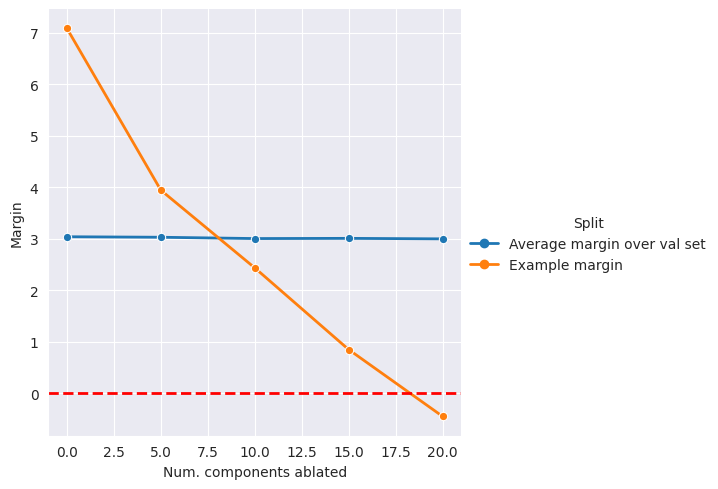

In [26]:
# iteratively ablate identified components and evaluate model performance 
eval_every = 5
masked_model = get_model().to(DEVICE)
rows = [] 

for k, (comp_name, comp_idx) in (pbar:=tqdm.tqdm(list(enumerate(ablate_set)))):
    if k % eval_every == 0:
        # eval + log
        masked_margins = eval_utils.get_margins(masked_model, loader_map['val'], DEVICE)
        margin_avg = np.mean(masked_margins) 
        example_margin = masked_margins[mi] 

        row = {
            'Num. components ablated': k,
            'Average margin over val set': margin_avg, 
            'Example margin': example_margin,
            'Accuracy': (masked_margins>0).mean()
        }

        rows.append(row)
        pbar.set_description('(avg:{:.2f}, example:{:.2f})'.format(margin_avg, example_margin))
        
        if example_margin < 0:
            break
    
    # ablate
    masked_model = editor.ablate_model_given_component(masked_model, comp_name, comp_idx)
    masked_model = masked_model.to(DEVICE).eval()
    
# plot effect of edit on model performance 
df = pd.DataFrame(rows)
pdf = df.melt(id_vars=['Num. components ablated'], 
              value_vars=['Average margin over val set', 'Example margin'],
              var_name='Split', 
              value_name='Margin')

sns.set_style('darkgrid')
fg = sns.relplot(data=pdf, 
                 x='Num. components ablated', 
                 y='Margin', 
                 hue='Split',
                 kind='line', 
                 lw=2, marker='o')

fg.axes[0,0].axhline(0, color='red', ls='--', lw=2)
fg.fig.suptitle

acc_before_edit = df.iloc[0]['Accuracy']
acc_after_edit = df[(df['Example margin']>0)].sort_values('Num. components ablated').iloc[0]['Accuracy']
print ('Accuracy: {:.3f} -> {:.3f}'.format(acc_before_edit, acc_after_edit))

### Apply Coar-Edit to correct a misclassification

In [31]:
# prepare inputs 
valid_inds = (margins>0).nonzero()[0]

misclassified_inds = (margins<0).nonzero()[0]
mi = misclassified_ind = np.random.choice(misclassified_inds)
print ('#{} ({} misclassified as {})'.format(mi, cnames[labels[mi]], cnames[preds[mi]]))
print ('Margin: {:.3f}'.format(margins[mi]))

num_ref = 50
ref_inds = np.random.choice(range(attb.shape[0]), size=num_ref, replace=False)
ref_attb = attb[ref_inds]
target_attb = attb[mi][None,:]

print ('target examples', target_attb.shape)
print ('reference examples', ref_attb.shape)

#20347 (altar misclassified as throne)
Margin: -2.391
target examples torch.Size([1, 22720])
reference examples torch.Size([50, 22720])


In [32]:
# use Coar-Edit to identify a subset of components to ablate 
subset_size = 200 # max number of components to ablate 
ablate_order = 'bottomk' # get components with most negative scores (to increase margin)

scores = editor.score_components(target_attb, ref_attb)
subset = editor.get_subset(scores, subset_size, ablate_order)
subset_inds = subset.indices.numpy()
ablate_set = [ndm_utils.get_component_from_index(ind, comps) for ind in subset_inds]
ablate_set[:10]

[('layer4.1.conv2.weight', 504),
 ('layer4.1.conv3.weight', 246),
 ('layer4.0.conv3.weight', 246),
 ('layer4.2.conv3.weight', 246),
 ('layer4.1.conv3.weight', 893),
 ('layer4.0.conv2.weight', 81),
 ('layer4.0.conv2.weight', 406),
 ('layer4.1.conv3.weight', 1693),
 ('layer4.2.conv1.weight', 1),
 ('layer4.0.conv3.weight', 511)]

(avg:3.03, example:0.31):   3%|█▎                                         | 6/200 [00:34<18:24,  5.69s/it]


Accuracy: 0.754 -> 0.753


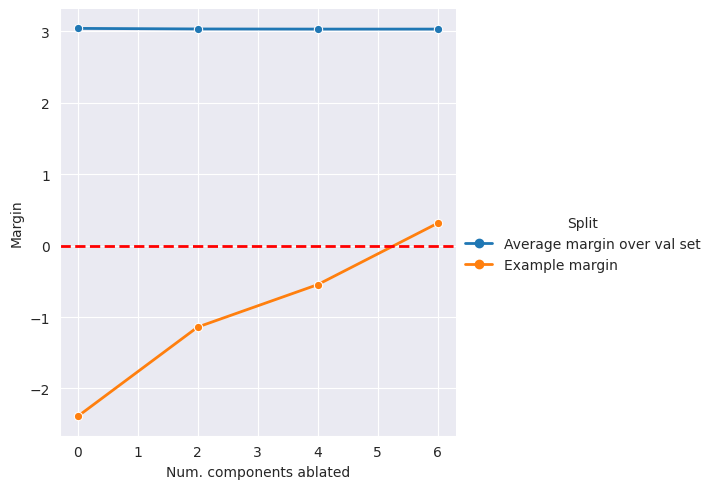

In [33]:
# iteratively ablate identified components and evaluate model performance 
eval_every = 2
masked_model = get_model().to(DEVICE)
rows = [] 

for k, (comp_name, comp_idx) in (pbar:=tqdm.tqdm(list(enumerate(ablate_set)))):
    if k % eval_every == 0:
        # eval + log
        masked_margins = eval_utils.get_margins(masked_model, loader_map['val'], DEVICE)
        margin_avg = np.mean(masked_margins) 
        example_margin = masked_margins[mi] 

        row = {
            'Num. components ablated': k,
            'Average margin over val set': margin_avg, 
            'Example margin': example_margin,
            'Accuracy': (masked_margins>0).mean()
        }

        rows.append(row)
        pbar.set_description('(avg:{:.2f}, example:{:.2f})'.format(margin_avg, example_margin))
        
        if example_margin > 0:
            break
    
    # ablate
    masked_model = editor.ablate_model_given_component(masked_model, comp_name, comp_idx)
    masked_model = masked_model.to(DEVICE).eval()
    
# plot effect of edit on model performance 
df = pd.DataFrame(rows)
pdf = df.melt(id_vars=['Num. components ablated'], 
              value_vars=['Average margin over val set', 'Example margin'],
              var_name='Split', 
              value_name='Margin')

sns.set_style('darkgrid')
fg = sns.relplot(data=pdf, 
                 x='Num. components ablated', 
                 y='Margin', 
                 hue='Split',
                 kind='line', 
                 lw=2, marker='o')

fg.axes[0,0].axhline(0, color='red', ls='--', lw=2)
fg.fig.suptitle

acc_before_edit = df.iloc[0]['Accuracy']

if len(df[(df['Example margin']>0)]):
    acc_after_edit = df[(df['Example margin']>0)].sort_values('Num. components ablated').iloc[0]['Accuracy']
else: 
    acc_after_edit = df.sort_values('Example margin').iloc[0]['Accuracy']
    
print ('Accuracy: {:.3f} -> {:.3f}'.format(acc_before_edit, acc_after_edit))